In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from IPython import display

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path) as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

display.display(pos_review.head(), neg_review.head())

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


,review,sentiment
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0


In [3]:
all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [4]:
import functools
import operator

def get_all_characters(df):
    chars = []
    for review in df.review:
        chars.append(list(review))
    chars = functools.reduce(operator.iconcat, chars, [])
    return list(set(chars))

In [5]:
chars = get_all_characters(all_reviews)

NUM_CHARS = len(chars)
print('Total number of characters: {}\n{}'.format(NUM_CHARS, chars))

Total number of characters: 87
[' ', 'm', 'z', 'f', 'ó', ']', 'w', '0', '[', 'b', 'h', 'ă', 'í', 'g', '3', 'ő', 'r', 'u', 'q', '–', '2', '>', 'ú', 'ę', 'ŕ', 'â', 'á', 'ć', 'v', '#', 'l', 'e', 'ç', '.', '&', '6', 'ö', '(', 'j', '˝', 'č', 'a', '?', '%', 'é', 't', ')', 'y', '`', '"', '=', "'", '$', '5', 'o', 'ű', '+', 's', '9', 'Ú', 'c', 'd', '4', 'ô', '…', '!', '<', 'x', 'ď', 'ń', '8', '-', '/', 'n', 'É', ';', 'i', '‘', 'p', '1', 'k', ':', '*', ',', '7', 'ü', '—']


In [6]:
char_to_num = {chars[i]: i for i in range(NUM_CHARS)}
num_to_char = {i: chars[i] for i in range(NUM_CHARS)}

Find the maximum length of review -- padding

In [7]:
def get_max_len(df):
    all_lenghts = []
    for review in df.review:
        all_lenghts.append(len(list(review)))
    return max(all_lenghts)

In [23]:
MAX_LEN = get_max_len(all_reviews)
print('Maximum length of review: {} (in characters)'.format(MAX_LEN))

Maximum length of review: 269 (in characters)


In [9]:
def review_to_one_hot(char):
    one_hot = [0] * NUM_CHARS
    pos = char_to_num[char]
    one_hot[pos] = 1
    return one_hot

def process_review(review, pad=True):
    review = list(review) # to characters
    review_one_hot = [review_to_one_hot(char) for char in review]
    if pad:
        # append 0 value padding
        while len(review_one_hot) < MAX_LEN:
            review_one_hot.append([0] * NUM_CHARS)
    return review_one_hot

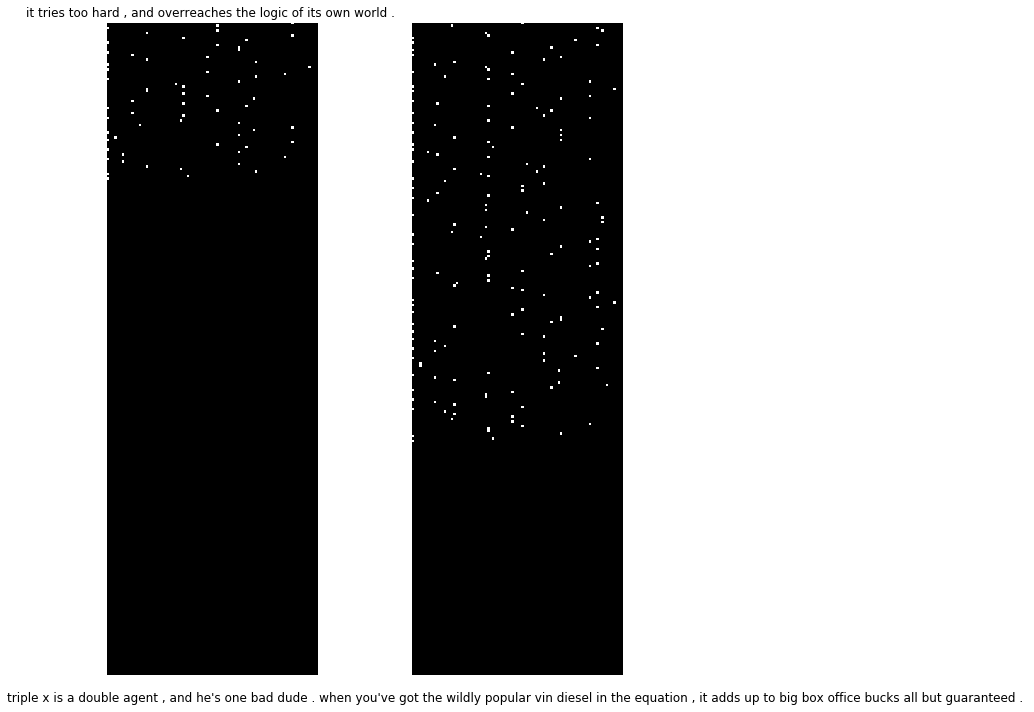

In [10]:
plt.figure(figsize=(10, 12))
plt.subplot(1, 2, 1)
plt.title(neg_review.review.iloc[2345])
plt.imshow([p for p in process_review(neg_review.review.iloc[2345])], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(pos_review.review.iloc[2345], y=-0.05)
plt.imshow([p for p in process_review(pos_review.review.iloc[2345])], cmap='gray')
plt.axis('off')

plt.show()

### TODOs:

- Create train and test dataset 
- Build CNN model
- Tune hyperparameters, also the MAX_LEN?
- Look at each layer weights (some patterns)

Data in format: 87x269

In [56]:
processed_review = all_reviews.review.apply(lambda review: process_review(review))

In [57]:
from sklearn.model_selection import train_test_split


X = processed_review.to_numpy().tolist()
y = all_reviews.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [85]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [98]:
X_train_reshaped = tf.reshape(X_train, [X_train.shape[0], X_train.shape[1], X_train.shape[2], 1])
X_test_reshaped = tf.reshape(X_test, [X_test.shape[0], X_test.shape[1], X_test.shape[2], 1])

In [100]:
X_train_reshaped.shape, X_test_reshaped.shape, y_train.shape, y_test.shape

(TensorShape([9595, 269, 87, 1]),
 TensorShape([1067, 269, 87, 1]),
 TensorShape([9595]),
 TensorShape([1067]))

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(MAX_LEN, NUM_CHARS, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [102]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 267, 85, 32)       320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 133, 42, 32)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 131, 40, 64)       18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 65, 20, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 63, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 31, 9, 64)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 29, 7, 64)       

In [103]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
history = model.fit(X_train_reshaped, 
                    y_train, 
                    epochs=10, 
                    batch_size=64,
                    validation_data=(X_test_reshaped, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 26s 3ms/sample - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5145
Epoch 2/10
9595/9595 [==============================] - 23s 2ms/sample - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5380
Epoch 3/10
9595/9595 [==============================] - 23s 2ms/sample - loss: 0.6927 - accuracy: 0.5200 - val_loss: 0.6900 - val_accuracy: 0.5267
Epoch 4/10
9595/9595 [==============================] - 23s 2ms/sample - loss: 0.6869 - accuracy: 0.5500 - val_loss: 0.6910 - val_accuracy: 0.5230
Epoch 5/10
9595/9595 [==============================] - 23s 2ms/sample - loss: 0.6782 - accuracy: 0.5706 - val_loss: 0.6886 - val_accuracy: 0.5586
Epoch 6/10
9595/9595 [==============================] - 23s 2ms/sample - loss: 0.6659 - accuracy: 0.5960 - val_loss: 0.6941 - val_accuracy: 0.5408
Epoch 7/10
9595/9595 [==============================] - 23s 2ms/sample

In [123]:
def predict(review):
    input_ = [p for p in process_review(review)]
    input_ = tf.cast(input_, tf.float32)
    input_ = tf.reshape(input_, (MAX_LEN, NUM_CHARS, 1))
    input_ = input_[np.newaxis, ...]
    print(model.predict(input_))

In [127]:
predict('this film is amazing. hope to see once again')

[[0.9998037]]


In [130]:
predict('one of the worse film i have ever seen, do not recommend')

[[0.23360966]]
